# Big Data for Biologists: Decoding Genomic Function- Class 9

## How do you visualize similarities and differences of gene expression profiles across cell types? Part III

##  Learning Objectives
***Students should be able to***
 <ol>
 <li> <a href=#Introkmeans>Explain what the k-means clustering algorithm is </a></li>
 <li> <a href=#Runkmeans>Perform k-means clustering to examine groups of samples from an RNA-Seq experiment.</a></li>
 <li> <a href=#Whileloop>Use a while loop to assess when the k-means clustering assignments are no longer changing.</a></li>
 <li> <a href=#heatmap>Interpret gene expression data in a heatmap </li>
 <li> <a href=#KmeansGenes> Perform k-means clustering to examine groups of genes from an RNA-Seq experiment. </a> </li>

# What is the K-means clustering algorithm?<a name='Introkmeans' />

In [1]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/4b5d3muPQmA" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>')


/opt/conda/lib/python3.7/site-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")




For this class we have prepared a number of helper functions in a file in **../helpers/kmeans_helpers.py** .

One of the helper functions makes scatter plots using code that is similar to what we saw in the last class. It adds some functionality to plot different styles of points or to change colors. 

We have also added a helper functions for importing RNA_Seq data in **../helpers/RNAseq_helpers.py**

You can take a look at either of the files by going into the helpers file or using the cat command to see what is there. 

In [2]:
!cat ../helpers/RNAseq_helpers.py

#helper scripts
def load_rnaseq_data(systems_subset,
                     rnaseq_data,
                     metadata):
    import pandas as pd
    data=pd.read_csv(
        filepath_or_buffer=rnaseq_data,
        header=0,
        index_col=0,
        sep='\t').transpose()
    metadata= pd.read_csv(
             filepath_or_buffer=metadata,
             header=0,
             index_col=0,
             sep='\t')
    nrow_data,ncol_data=data.shape
    nrow_metadata,ncol_metadata=data.shape 
    merged_df=pd.merge(data, metadata, left_index=True,right_index=True)
    if systems_subset=="all":
        data_filtered=merged_df.iloc[:,0:ncol_data].transpose()
        metadata_filtered=merged_df.iloc[:,0:-1*ncol_metadata]
    else:
        samples_to_keep=merged_df['System'].isin(systems_subset)
        merged_df_subset=merged_df[samples_to_keep]
        data_filtered=merged_df_subset.iloc[:,0:ncol_data].transpose()
        metadata_filtered=merged_df_subset.iloc[:,0:-1*ncol_metadata]
    retu

In [3]:
!cat ../helpers/kmeans_helpers.py

import random
import numpy as np
import pandas as pd 
import math 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from plotnine import * 

red='#ff0000'
black='#000000'
blue='#0000ff'
green='#00ff00'
purple='#800080'
orange='#FFA500'
gray='#808080'
color_options=[red,blue,green,purple,orange,gray]

def generate_random_data(N):
    c1=np.random.normal([-2,2],0.5,([int(N/3),2]))
    c2=np.random.normal([0,1],0.5,([int(N/3),2]))
    c3=np.random.normal([2,2],0.5,([int(N/3),2]))
    A=list(c1[:,0])+list(c2[:,0])+list(c3[:,0])
    B=list(c1[:,1])+list(c2[:,1])+list(c3[:,1])
    return A,B


def get_color_assignments(cluster_assignments,num_points):
        #define the colors we will use for the plot
        if cluster_assignments==None:
                    return [black]*num_points
        else:
            colors=[]
            for c in cluster_assignments:
                colors.append(color_options[

In [4]:
#Imports helper functions for loading RNA_Seq data and kmeans algorithm 

%matplotlib inline
%load_ext autoreload
%reload_ext autoreload

%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('../helpers')
from kmeans_helpers import * 
from RNAseq_helpers import * 

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.

In [5]:
#Step 1: Generate a dataset in 2 dimensions with 150 datapoints 
x,y=generate_random_data(150)

In [6]:
len(x)

150

In [7]:
len(y)

150

We plot the data:

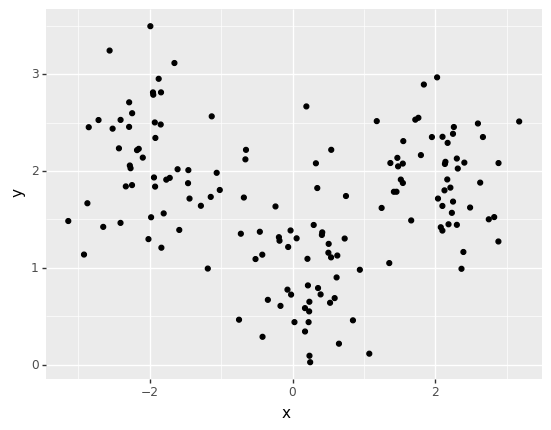

<ggplot: (8783981952041)>

In [8]:
plot(x,y)

Thought question: Why can we use the simple command plot to make this plot rather than the long list of commands that we used in the last class? 

Based on a visual inspection of the data, we decide that we would like 3 clusters. It looks like all the data points fall in the range of [-5,5].

In [9]:
k=3
min_val=-5
max_val=5 

The first step in the algorithm is to randomly initialize the cluster centroids. We can do this with the **initialize_centroids** function that was imported from kmeans_helpers. First, let's use the **help()** function to examine the **initialize_centroids** function. 

In [10]:
help(initialize_centroids)

Help on function initialize_centroids in module kmeans_helpers:

initialize_centroids(k, min_val, max_val)
    k -- the number of centroids to initialize. This is equal to the number of clusters to generate. 
    min_val -- the minimum allowed centroid coordinate (same for both x and y coordinates). 
    max_val -- the maximum allowed centroid coordinate (same for both x and y coordinates). 
    
    returns two lists: the x and y coordinates of the generated centroids.



In [11]:
x_centroids,y_centroids=initialize_centroids(k,min_val,max_val)

x-coordinates of centroids:[-4.293540616865007, -0.16903093581186646, -4.1132007595668245]
y-coordinates of centroids:[-2.3492384968179767, -0.7654659769245722, -2.4764602158123115]


Thought question: Where could you find the code for the initialize_centroids function either to understand each step or to view if your code needed debugging?  

Plot the cluster centroids that we initialized above:

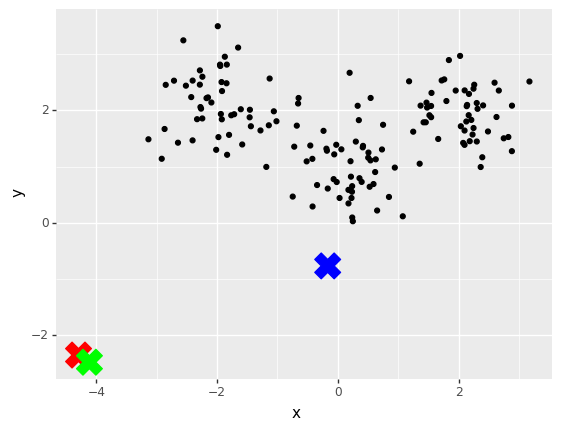

<ggplot: (8783843663761)>

In [12]:
plot(x,
     y,
     x_centroids=x_centroids,
     y_centroids=y_centroids)

We would like to find the closest centroid to each point. To do this, we will calculate the Euclidean distance from each point to each centroid. Euclidean distance can be found with the formula below: 
![euclidean distance formula](../Images/euclidean_distance.png)


In [13]:
help(distance)

Help on function distance in module kmeans_helpers:

distance(x, y, x_centroid, y_centroid)
    x -- list containing the x-coordinates of the points in the dataset 
    y -- list containing the y-coordinates of the points in the dataset 
    x_centroid -- x-coordinate of the centroid 
    y_centroid -- y-coordinate of the centroid 
    returns a list of Euclidean distances from each point to the centroid.



In [14]:
#Calculate the distance of each point to each centroid. 
distances=[] 
for cluster_index in range(k): 
    cluster_distance=distance(x,
                              y,
                              x_centroids[cluster_index],
                              y_centroids[cluster_index])
    distances.append(cluster_distance)

print("length of distances: "+ str(len(distances)))
print(distances[0][0:10])
print ("length of distances each cluster: "+str(len(distances[1])))

length of distances: 3
[5.854422395423711, 4.261671808280838, 5.2070185100496404, 4.824946716458732, 4.300063846791998, 4.619523389887859, 5.200085934616679, 5.827319785257778, 5.646325912740146, 6.280857275757255]
length of distances each cluster: 150


Thought questions: 

Why is the length of distances 3? What does each sublist represent? 

The variable distances is defined as "distances=[ ]"in the code above and it is also defined as "distances=[ ]" as the first line in the distance helper function defined in kmeans_helpers.py. Why do the distances for each centroid get appended to distances instead of getting erased each time the for loop gets called for a new centroid?

In [15]:
#Assign each point to the cluster corresponding to the nearest centroid. 
num_points=len(x)
print(len(x))
cluster_assignments=assign_cluster(distances,num_points)

150


In [16]:
print(cluster_assignments)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


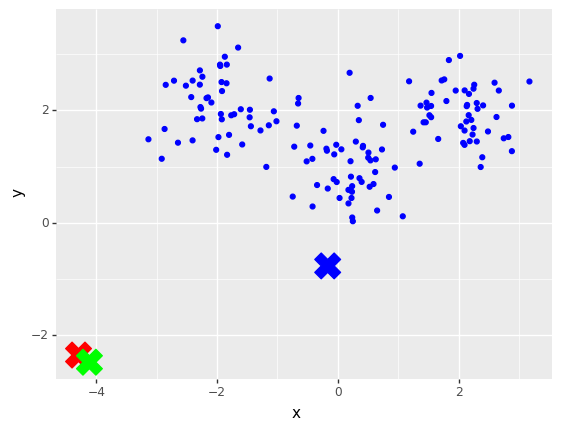

<ggplot: (8783843608385)>

In [17]:
#plot the data with cluster assignments --red indicates points in cluster 0, blue in cluster 1 and green in cluster 2. 
plot(x,
     y,
     x_centroids=x_centroids,
     y_centroids=y_centroids,
     cluster_assignments=cluster_assignments)

Now, we re-calculate the centroid positions so that the centroids are at the mid-point of each cluster. We use the helper function 'update_centroids' that is defined in helpers/kmeans_helpers.py

updated x_centroids:[0, 0.08569808318873215, 0]
updated y_centroids:[0, 1.6940736938882883, 0]


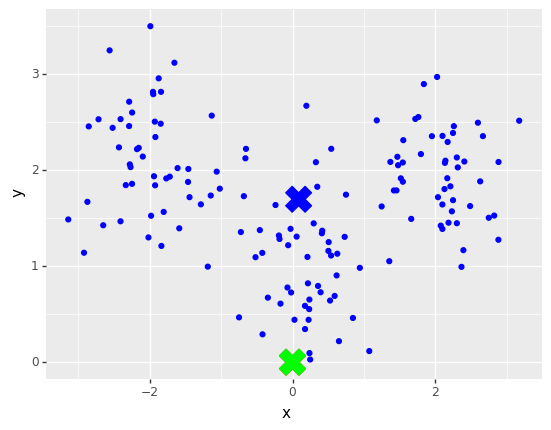

<ggplot: (8783843582005)>

In [18]:
#call the function to update the centroids 
x_centroids,y_centroids=update_centroids(x,y,cluster_assignments,k)
print("updated x_centroids:"+str(x_centroids))
print("updated y_centroids:"+str(y_centroids))
plot(x,
    y,
    cluster_assignments=cluster_assignments,
    x_centroids=x_centroids,
    y_centroids=y_centroids)

In [19]:
# We repeat this cycle of assigning points to cluster and updating the cluster centroids. 
# At each iteration, you should observe an improved separation of the datapoints. 


#We combine the functions we have written above to produce a full iteration of the k-means clustering algorithm. 
def iterate(x,y,x_centroids,y_centroids,k): 
    num_points=len(x)
    
    #calculate centroid distances 
    distances=[] 
    for cluster_index in range(k): 
        distances.append(distance(x,y,x_centroids[cluster_index],y_centroids[cluster_index]))
        
    #Assign each point to the cluster corresponding to the nearest centroid. 
    cluster_assignments=assign_cluster(distances,num_points)

    #update the centroid assignments 
    x_centroids,y_centroids=update_centroids(x,y,cluster_assignments,k)
    
    #generate a plot 
    print(plot(x,
        y,
        x_centroids=x_centroids,
        y_centroids=y_centroids,
        cluster_assignments=cluster_assignments))
    
    #return the new cluster assignments and centroid values 
    return cluster_assignments,x_centroids,y_centroids

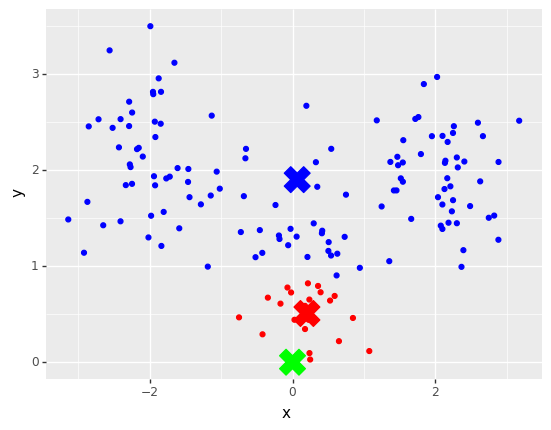

In [20]:
#run an iteration of the algorithm 
#run this code block several times to observe progress improvements in cluster assignments 
cluster_assignments,x_centroids,y_centroids=iterate(x,y,x_centroids,y_centroids,k)

 ## Use a while loop to assess when the k-means clustering assignments are no longer changing.<a name='Whileloop' />

In [21]:
#Finally, we define the end-criteria -- the algorithm is complete when the cluster assignments are no longer changing. 
def check_finished(old_cluster_assignments,new_cluster_assignments): 
    for i in range(len(old_cluster_assignments)): 
        if old_cluster_assignments[i]!=new_cluster_assignments[i]: 
            return False 
    return True 

In [22]:
#We put all the steps above together to define the full k-means clustering algorithm 
def k_means(x,y,k): 
    min_val=min(x+y)
    max_val=max(x+y)
    x_centroids,y_centroids=initialize_centroids(k,min_val,max_val)
    cluster_assignments,x_centroids,y_centroids=iterate(x,y,x_centroids,y_centroids,k)
    finished=False 
    while (finished==False): 
        new_assignments,x_centroids,y_centroids=iterate(x,y,x_centroids,y_centroids,k)
        finished=check_finished(cluster_assignments,new_assignments)
        cluster_assignments=new_assignments
    return cluster_assignments

x-coordinates of centroids:[-2.4188006109348548, 2.6834533112673458, 0.7534913458846635]
y-coordinates of centroids:[-0.5226790455733981, -2.8279182426027107, -1.4538012053046143]


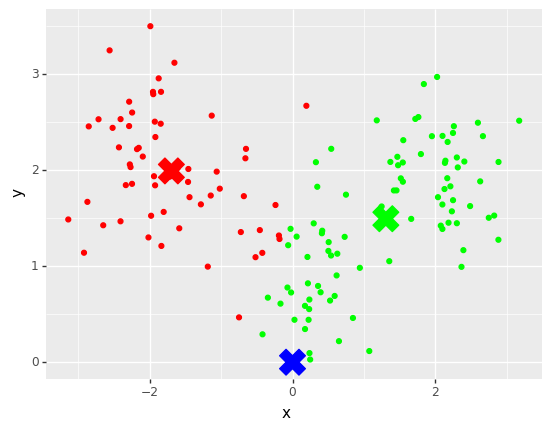

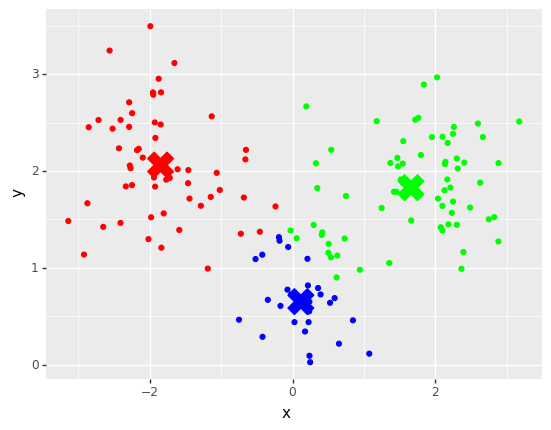

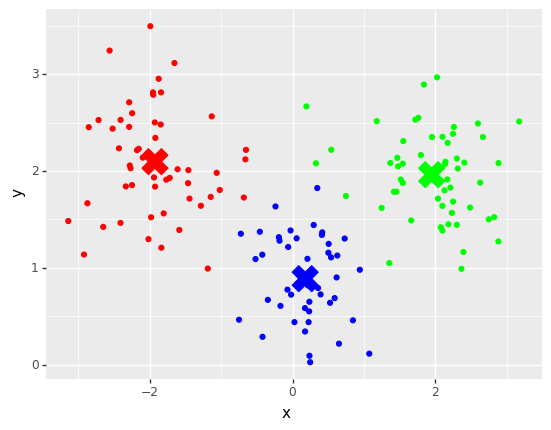

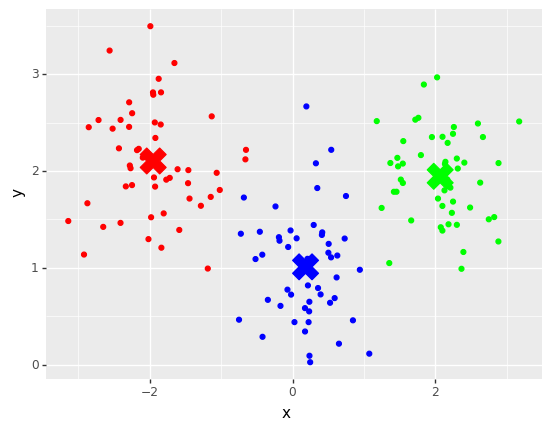

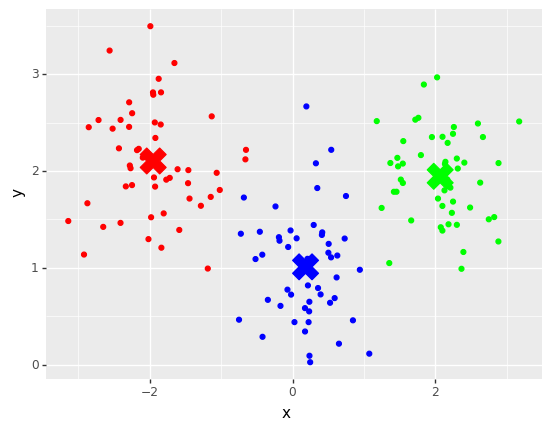

In [23]:
#Let's run the full algorithm on our toy dataset 
cluster_assignments=k_means(x,y,3)

What would happen if you chose a different value of k (number of clusters)? 


x-coordinates of centroids:[2.01862619260169, -0.22102293415438234]
y-coordinates of centroids:[-0.04097831016093867, -0.6689569411045828]


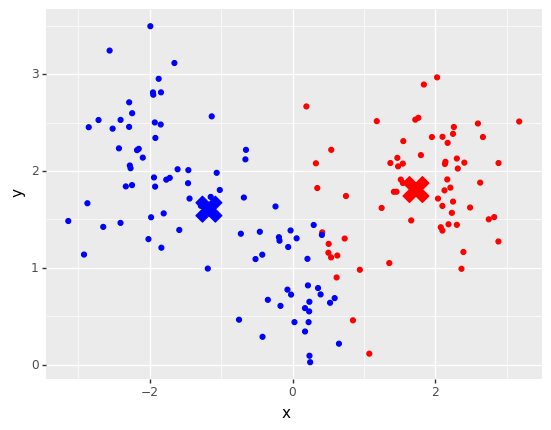

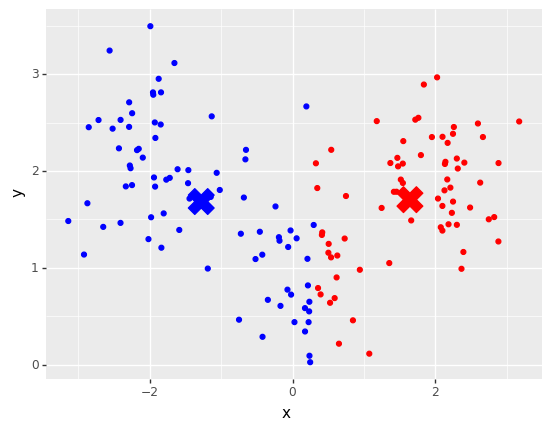

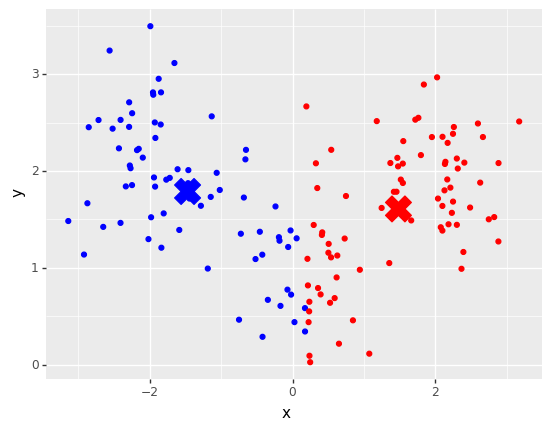

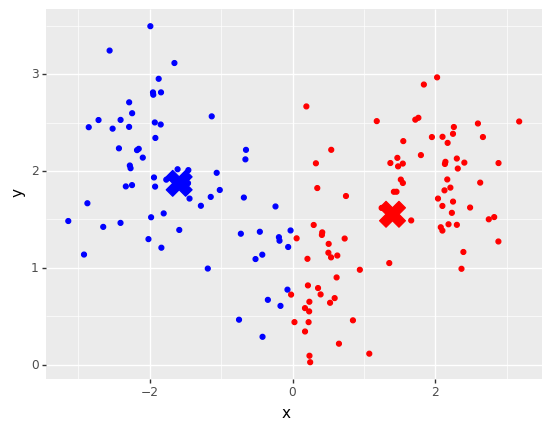

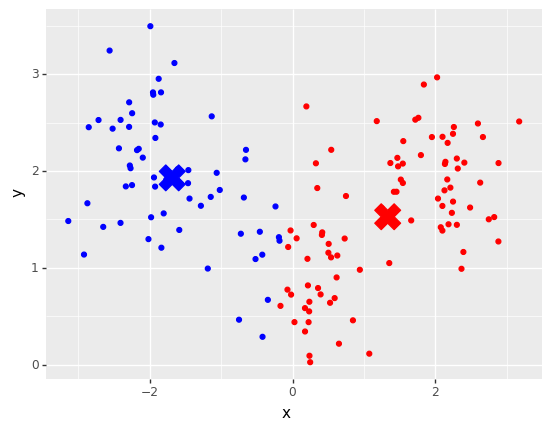

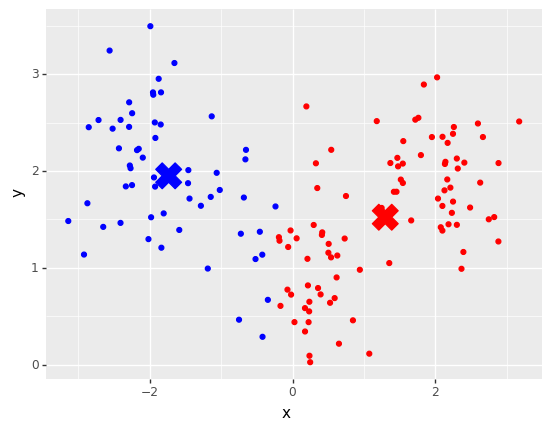

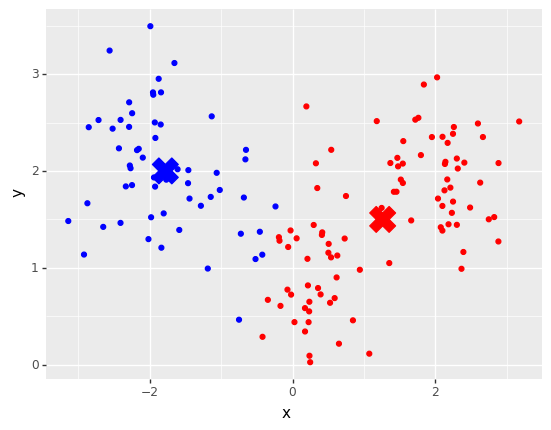

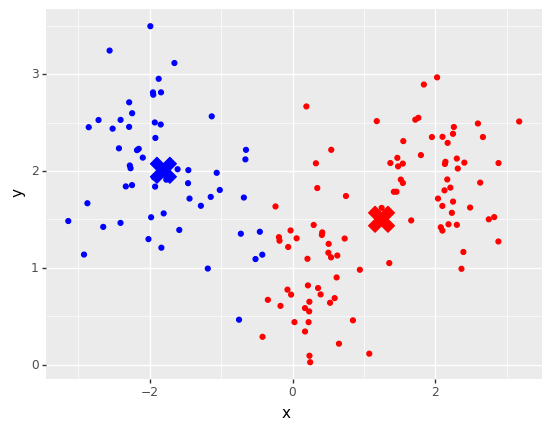

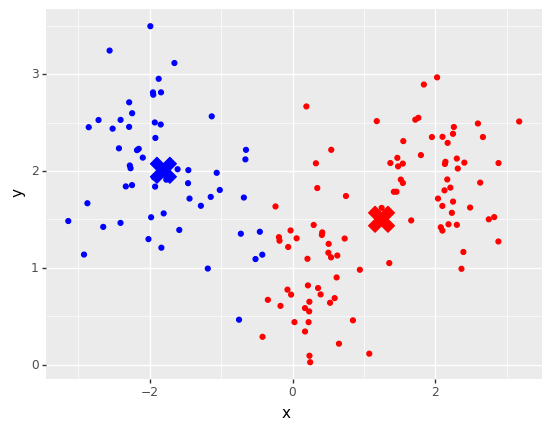


x-coordinates of centroids:[0.9544095645257387, -0.21677413427832182, 1.6807533506846917, 0.44407515663092134]
y-coordinates of centroids:[3.340376160441156, -0.6462575981133027, -2.8399658483792516, -0.345449746564098]


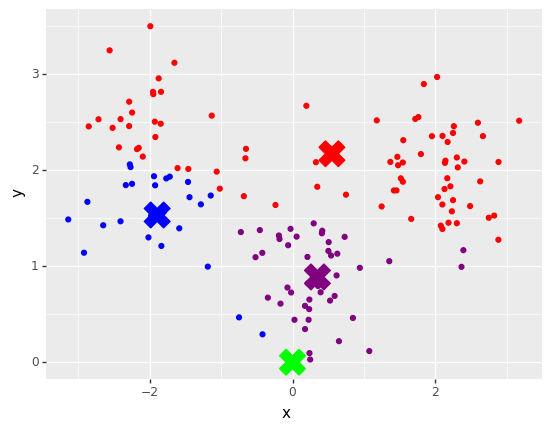

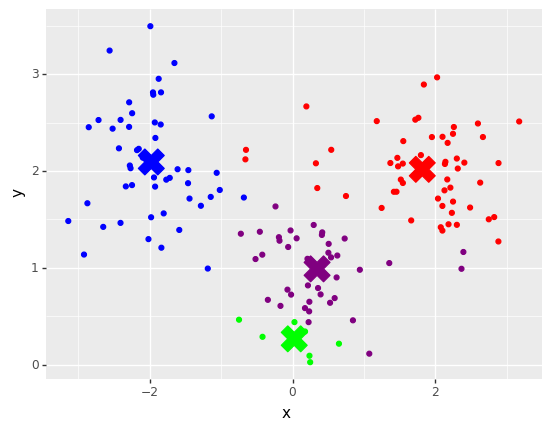

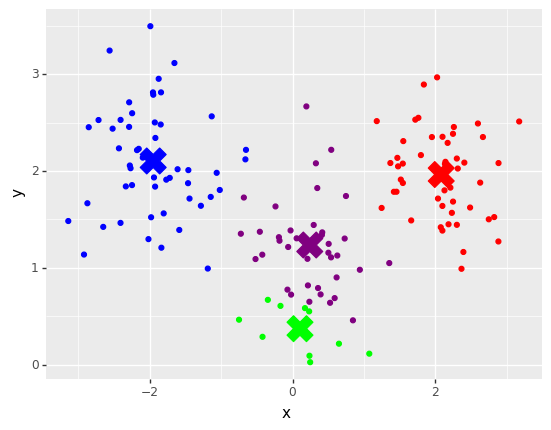

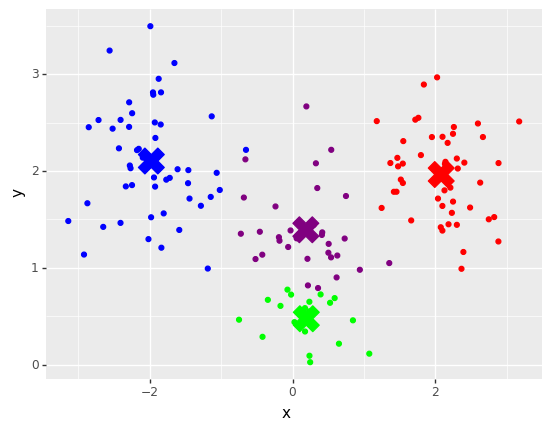

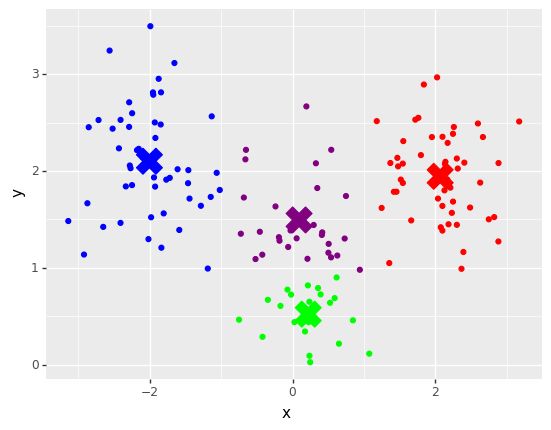

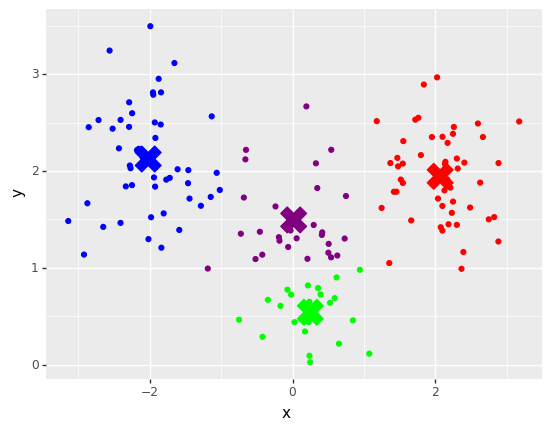

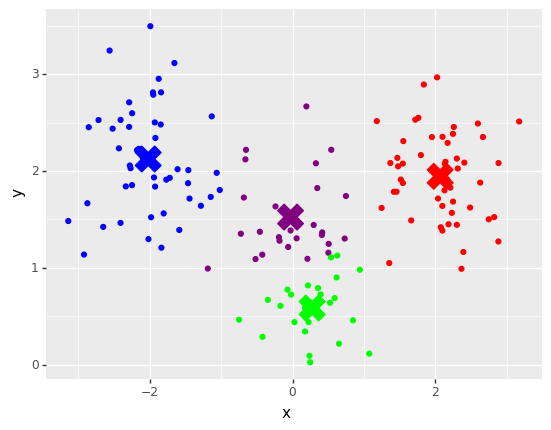

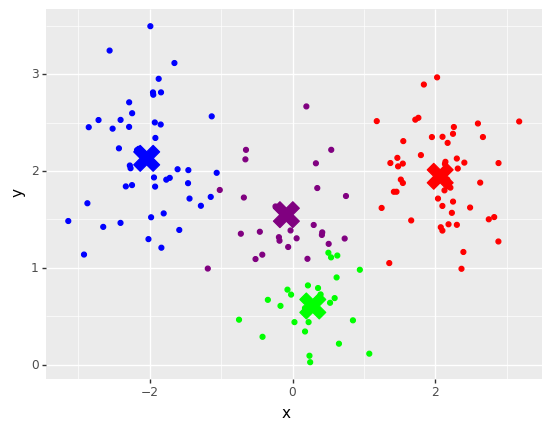

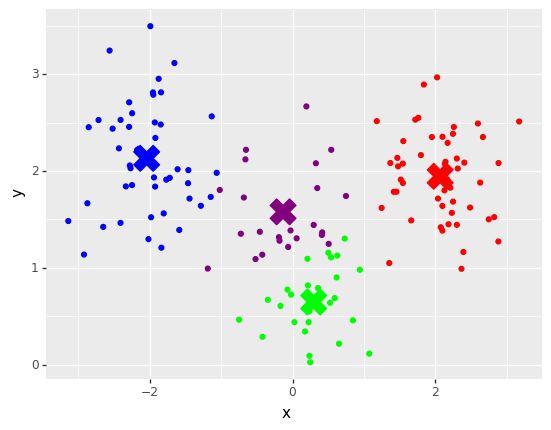

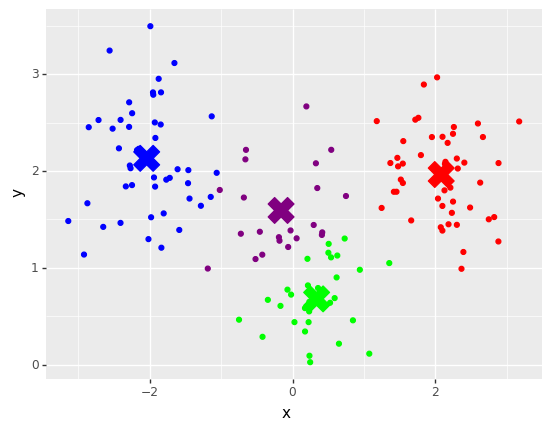

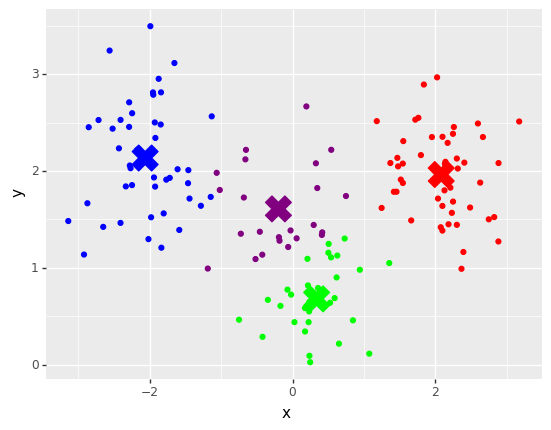

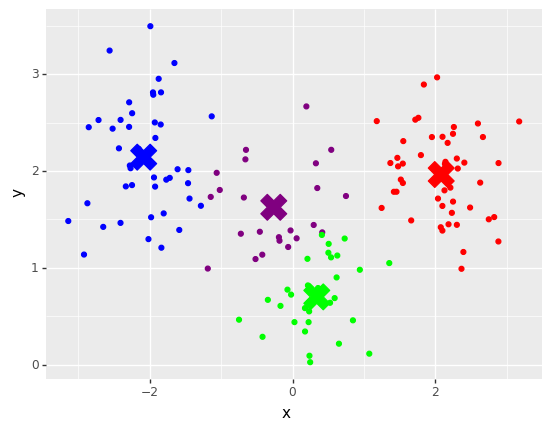

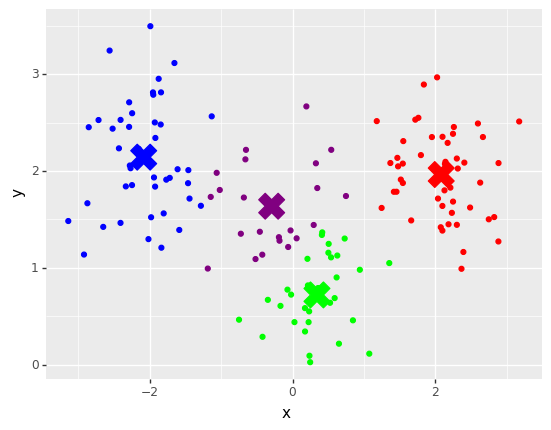

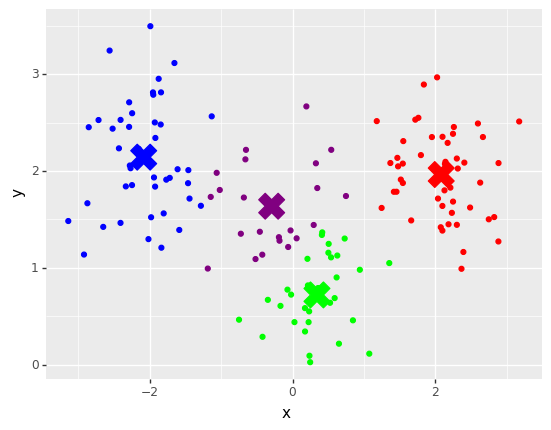

In [24]:
#Use the k_means function defined above to run k-means clustering 
#on x,y for k=2 and k=4. 

## BEGIN SOLUTION ## 
## END SOLUTION ## 

#Which value of k (2,3, or 4) gives the best separation of the datapoints into cohesive clusters? 
## BEGIN SOLUTION ## 
## END SOLUTION ## 

# Using K-means clustering to examine groups of samples from an RNA-Seq experiment. <a name='Runkmeans' />

We will now use kmeans clustering to cluster our samples across the four organ systems: 

* Blood 
* Embryonic
* Immune 
* Respiratory 

In [26]:
import pandas as pd 
systems_subset=["Blood","Embryonic","Immune","Respiratory"]
rnaseq_data,metadata=load_rnaseq_data(systems_subset=systems_subset,rnaseq_data='/data/datasets/RNAseq/diff_genes_top.tsv',
                              metadata='/data/datasets/RNAseq/rnaseq_metadata.txt')
rnaseq_data_transposed=rnaseq_data.transpose()

#Write a line of code to check the top few lines of the rnaseq_data_transposed matrix.  
## BEGIN SOLUTION ##
## END SOLUTION ## 

,ENSG00000269416.1,ENSG00000008517.12,ENSG00000158966.9,ENSG00000167768.4,ENSG00000147257.9,ENSG00000169992.5,ENSG00000143248.8,ENSG00000232301.1,ENSG00000083857.9,ENSG00000165272.10,...,ENSG00000091136.9,ENSG00000081059.15,ENSG00000149131.11,ENSG00000100055.16,ENSG00000211675.2,ENSG00000100167.15,ENSG00000129226.9,ENSG00000211660.3,ENSG00000172116.17,ENSG00000264198.1
ENCSR762CJN.H1_BMP4_Derived_Trophoblast_Cultured_Cells.UCSD_Thompson,1.072950,2.909363,1.078614,0.397604,3.990381,3.407149,3.257987,0.005018,3.574443,3.438093,...,6.419253,2.399142,3.367401,0.706757,-0.041462,2.173316,0.624818,-0.608041,0.534428,0.068577
ENCSR109IQO.K562_Leukemia_Cells.UConn_Graveley,0.286721,3.208843,0.805963,0.328598,1.014792,1.338217,0.979859,-0.056374,2.254482,1.501592,...,1.691900,1.859431,3.132182,3.002573,0.959441,0.908607,4.097401,2.098183,0.105900,1.830733
ENCSR000AEF.GM12878_Lymphoblastoid_Cells.UConn_Graveley,-0.213324,3.620727,0.937963,0.473357,0.566537,1.175141,2.701583,-0.550125,0.075499,0.024138,...,0.759223,4.161725,1.493571,3.774258,0.591385,1.785459,2.866864,8.104701,0.362652,3.830373
ENCSR000CUA.Primary_hematopoietic_stem_cells.CSHL_Gingeras,0.783033,2.229320,1.652827,0.380696,2.256879,2.514402,2.137356,0.074961,2.154409,1.766349,...,2.129267,1.867399,3.626299,2.163802,0.198878,0.914617,2.815205,0.187306,0.416518,0.398710
ENCSR000AAN.Pulmonary_Artery_Smooth_Muscle_Primary_Cells.CSHL_Gingeras,0.668882,2.712193,0.866142,0.448591,1.309743,3.276612,5.126548,0.352272,5.151749,1.926669,...,6.143811,0.974064,2.985356,0.535666,0.556397,0.906949,3.811450,0.020765,0.627301,0.339167


In [27]:
rnaseq_data_transposed.shape

(116, 1543)

Note that our matrix has 1543 columns (1 per gene) and 116 rows (1 per sample). Why do we examine only 1543 genes from the original set of 55,000 genes in the human genome? These 1543 genes were found to have different levels of expression across the four organ systems in **systems_subset**. The remaining genes did not show a significant difference in expression across the blood, embryonic, immune, and respiratory systems. 

In the example above, we wrote the k-means clustering code "from scratch". However, python already has a KMeans clustering function in the scikit learn library, which is more efficient for clustering large datasets than the function that we wrote above. We will use the built-in KMeans function in our further data analysis. 

In [28]:
from sklearn.cluster import KMeans

In [29]:
#use the help command to learn more about the KMeans clustering function. 
#Uncomment the following line of code to run the "help" function 
## BEGIN SOLUTION ## 
## END SOLUTION ## 

Help on class KMeans in module sklearn.cluster.k_means_:

class KMeans(sklearn.base.BaseEstimator, sklearn.base.ClusterMixin, sklearn.base.TransformerMixin)
 |  KMeans(n_clusters=8, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='auto', verbose=0, random_state=None, copy_x=True, n_jobs=None, algorithm='auto')
 |  
 |  K-Means clustering
 |  
 |  Read more in the :ref:`User Guide <k_means>`.
 |  
 |  Parameters
 |  ----------
 |  
 |  n_clusters : int, optional, default: 8
 |      The number of clusters to form as well as the number of
 |      centroids to generate.
 |  
 |  init : {'k-means++', 'random' or an ndarray}
 |      Method for initialization, defaults to 'k-means++':
 |  
 |      'k-means++' : selects initial cluster centers for k-mean
 |      clustering in a smart way to speed up convergence. See section
 |      Notes in k_init for more details.
 |  
 |      'random': choose k observations (rows) at random from data for
 |      the initial centro

In [30]:
#use the help command to learn more about the scikit_PCAandkmeans helper function. 
## BEGIN SOLUTION ## 
## END SOLUTION ## 

Help on function scikit_PCAandkmeans in module kmeans_helpers:

scikit_PCAandkmeans(data, n_clusters, xlabel, ylabel, plottitle)



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a dep

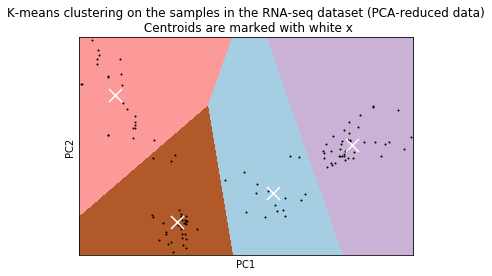

For n_clusters = 4 The average silhouette_score is : 0.6672728213800275


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a dep

In [31]:
#Run the kmeans clustering algorithm on the data with four clusters
## BEGIN SOLUTION ## 
## END SOLUTION ## 

We would like a way to determine how well the k-means clustering has separated the data. One way to assess the performance of the clustering algorithm is to compare inter-cluster distance to intra-cluster distance. We would like points in the same cluster to be near each other, and points that are in different clusters to be far apart: 
![Inter-cluster and intra-cluster distance](../Images/inter_cluster_vs_intra_cluster.png)

**Silhouette analysis** allows us to compute the ratio of inter-cluster distance to intra-cluster distance for each cluster. This measure has a range of [-1, 1]. We see above that the clustering analysis yields a silhouette score of 0.66, suggesting that the data is fairly well-separated by four clusters. 


# Interpreting gene expression data in a heatmap <a name='heatmap' />

In [32]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/oMtDyOn2TCc" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>')

We can visualize the 116 clustered samples in a heatmap, with samples along the y-axis and genes along the x-axis.  Note how we can see four distinct clusters  in the data. The heatmap values correspond to gene expression levels for each gene in each sample.

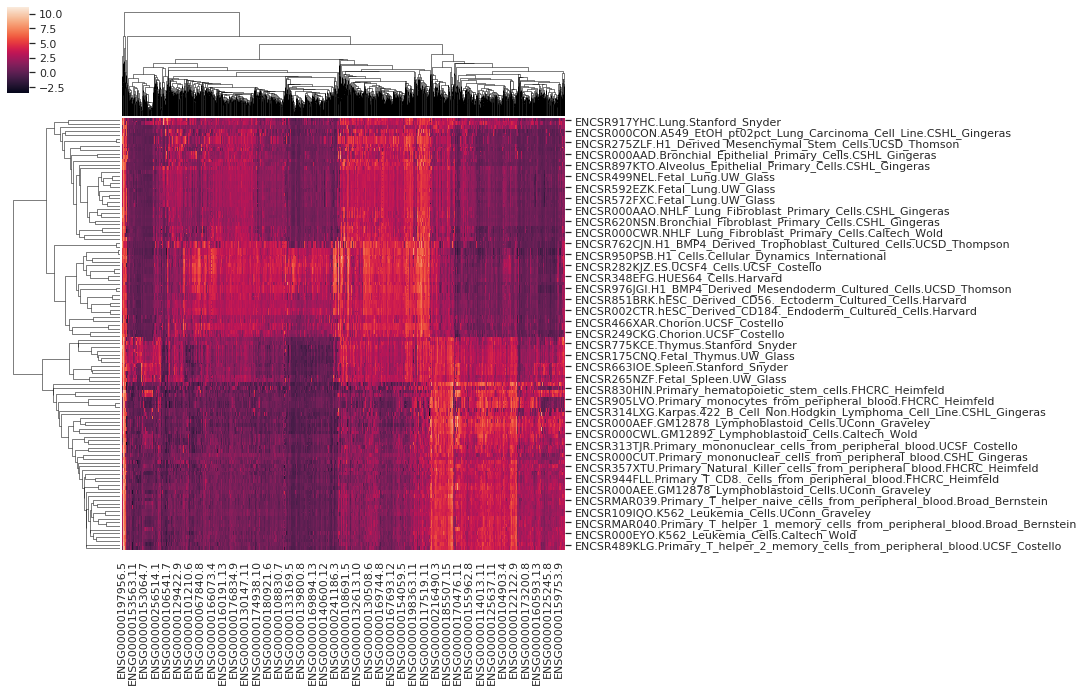

In [33]:
plot_heatmap(rnaseq_data_transposed)

Thought questions: 
* What does each box in the heatmap represent?
* What does each column represent?
* What does each row represent?  

## Perform k-means clustering to examine groups of genes from an RNA-Seq experiment <a name='KmeansGenes' />

Previously, we performed k-means clustering on the samples. Now, we are interested in identifying groups of genes with similar patterns of expression across organ systems. To perfom clustering on the genes, we will reverse the axis (switch the rows and columns) in the input dataset.

Let's begin with 4 clusters (k=4). 

Above, when we read in our dataset, we used a command **data.transpose()** to put the sample names as the rows and the genes as the columns. 

Now, we want to use the original data matrix with 1543 rows (which corresponds to the number of genes) and 116 columns (corresponding to the number of samples). 

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a dep

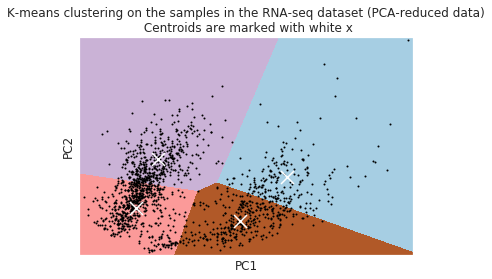

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a dep

For n_clusters = 4 The average silhouette_score is : 0.4391810994909346


In [34]:
#Fill in the code below to run the k-means clustering on the genes. 
## BEGIN SOLUTION ## 
## END SOLUTION ## 

In [35]:
#To see what the output of the kmeans clustering looks like, print the first ten lines
print(clusters[0:10])

[0 2 0 0 3 3 3 0 3 0]


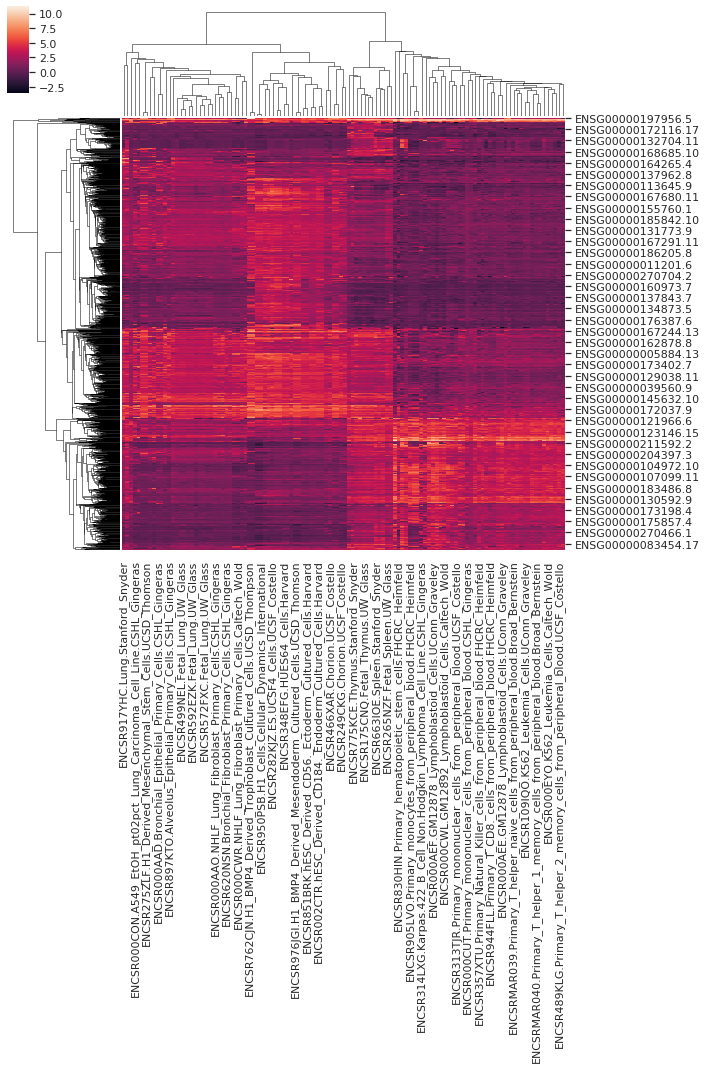

In [36]:
# Plot a heatmap of the data 
plot_heatmap(rnaseq_data)

We now obtain the list of genes associated with each cluster using the 'get_genes_from_cluster' function in ../helpers/kmeans_helpers.py

In [37]:
get_genes_from_clusters(rnaseq_data,clusters,k,filename='gene_id_to_gene_name.txt')

This will generate files 0.txt, 1.txt, 2.txt, and 3.txt -- listing the genes associated with each cluster. 


In [38]:
#Examine the first 10 lines in the file 0.txt
! head 0.txt

LINC01224
CACHD1
KRT1
RP11-132A1
AQP3
TNNT1
DEFA1
PHLDA2
TBX2
RP11-166D19
